In [1]:
# 0. Import dependencies and define classes
import json
import numpy as np
import scipy
import torch
import torchaudio
import os
import xtalkdemixhelpers as xdmx
import matplotlib.pyplot as plt
from pathlib import Path

class MixMatrixInverter(torch.nn.Module):
    def __init__(self,
                Fs=44100,
                LENFILT=1023,
                fc=16000,
                order=4):
        super().__init__()
        self.Fs = Fs
        self.LENFILT = LENFILT
        self.fc = fc
        self.order = order

    def forward(self, hL: torch.Tensor, hR: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        gl, gr = xdmx.mixmatrix_to_demix3(hL.numpy(), hR.numpy(),LENFILT=self.LENFILT,Fs=self.Fs,fc=self.fc,order=self.order)
        gl = torch.from_numpy(gl)
        gr = torch.from_numpy(gr)
        return gl, gr

def select_components(S, threshold=0.99):
    # Compute the total variance
    total_variance = torch.sum(S**2)

    # Initialize cumulative variance
    cumulative_variance = 0.0

    # Initialize the number of components
    num_components = 0

    # For each component...
    for variance in S**2:
        # Update the cumulative variance
        cumulative_variance += variance

        # Update the number of components
        num_components += 1

        # If the ratio of cumulative variance to total variance exceeds the threshold...
        if cumulative_variance / total_variance >= threshold:
            # Break the loop
            break

    # Return the number of components
    return num_components



In [2]:

# 1. Define data directories and read metadata of HRTF database

metadatadir = "/Users/sridhar/Documents/Projects/clarity/clarity/cad_icassp_2024/metadata"
hrtf_dir = "/Users/sridhar/Documents/Projects/clarity/clarity/cad_icassp_2024/audio/hrtf"
audio_dir = "/Users/sridhar/Documents/Projects/clarity/clarity/cad_icassp_2024/audio/at_mic_music"
DEMIXFILTLEN = 1999
Fs = 44100


# Load the spatial configurations metadata
spatconfigs_file = Path(metadatadir,"head_loudspeaker_positions.json")
with open(spatconfigs_file, encoding="utf-8") as f:
    spatconfigs_metadata = json.load(f)
spatconfigslabels = list(spatconfigs_metadata.keys())

In [3]:
#device = (
#    "cuda"
#    if torch.cuda.is_available()
#    else "mps"
#    if torch.backends.mps.is_available()
#    else "cpu"
#)
demixfile = Path(os.getcwd(),f"demixirs_len{DEMIXFILTLEN}")
if 0:
    device = "cpu"
    demixmatrix = MixMatrixInverter(LENFILT=DEMIXFILTLEN)
    demixmatrix.to(device)
    nscenes = len(spatconfigslabels)
    glall = torch.zeros((DEMIXFILTLEN,2,nscenes))
    grall = torch.zeros_like(glall)

    for idx, label in enumerate(spatconfigslabels):
        configdict = spatconfigs_metadata[f"{label}"]
        # get hrtfs corresponding to the spatial configuration of the scene, where
        # hL is the binaural pair of impulse responses for stimulus at Left loudspeaker
        # hR is the binaural pair of impulse responses for stimulus at right loudspeaker
        hL, hR = xdmx.load_hrtf_signals(hrtf_dir,configdict)
        # gl is the pair of demix impulse responses to apply to left ear
        # gr is the pair of demix impulse responses to apply to right ear
        with torch.no_grad():
            hL = torch.from_numpy(hL).to(torch.float32)
            hR = torch.from_numpy(hR).to(torch.float32)
        if 0: #for testing, eliminate any mixing so that demixing filter is directly the inverse HRIR 
            hL[:,1] = 0
            hR[:,0] = 0
        

        gl, gr = demixmatrix(hL.to(device), hR.to(device))
        if 0:
            if idx == 0:
                glall = gl.unsqueeze(dim=-1)
                grall = gr.unsqueeze(dim=-1)
            else:
                glall = torch.cat((glall,gl.unsqueeze(dim=-1)),dim=-1)
                grall = torch.cat((grall,gr.unsqueeze(dim=-1)),dim=-1)
        else: 
            glall[:,:,idx] = gl
            grall[:,:,idx] = gr

    torch.save({'gl': glall, 'gr': grall},demixfile)
else:
    demixfilters = torch.load(demixfile)
    glall = demixfilters["gl"]
    grall = demixfilters["gr"]

In [ ]:
tmh = 1000/44100*np.arange(235)
tmg = 1000/44100*np.arange(1023)
plt.subplot(2,2,1)
plt.plot(tmg,np.real(gl3[:,0]),'b')
plt.plot(tmh,hL[:,0],'m')
plt.subplot(2,2,2)
plt.plot(scipy.signal.fftconvolve(hL[:,0],gl3[:,0],mode='full'),'b')
plt.subplot(2,2,3)
plt.plot(tmg,gl3)
plt.subplot(2,2,4)
plt.plot(tmg,gr3)
w, HLl = scipy.signal.freqz(hL[:,0],fs=44100)
_, Gl3l= scipy.signal.freqz(gl3[:,0],fs=44100)
_, Gl3r = scipy.signal.freqz(gl3[:,1],fs=44100)
_, Gr3l = scipy.signal.freqz(gr3[:,0],fs=44100)
_, Gr3r = scipy.signal.freqz(gr3[:,1],fs=44100)


#plt.subplot(2,1,1)
plt.plot(w,20*np.log10(np.abs(HLl)),'k-',w,20*np.log10(np.abs(Gl3l)),'b:')
plt.plot(w,20*np.log10(np.abs(Gl3r)),'b--',w,20*np.log10(np.abs(Gr3l)),'r:')
plt.plot(w,20*np.log10(np.abs(Gr3r)),'r--')

#plt.subplot(2,1,2)
#plt.plot(w,np.unwrap(np.angle(HLl)),'k',w,np.unwrap(np.angle(Gl3)),'b')
_, g_dL = scipy.signal.group_delay((hL[:,0],1))
gdmn = scipy.stats.trim_mean(g_dL,0.01)
plt.subplot(2,2,1)
plt.hist(g_dL)
print(f"gd_Ll ms = {gdmn/44.100}")
_, g_dL = scipy.signal.group_delay((hL[:,1],1))
gdmn = scipy.stats.trim_mean(g_dL,0.01)
plt.subplot(2,2,2)
plt.hist(g_dL)
print(f"gd_Lr ms = {gdmn/44.100}")
_, g_dR = scipy.signal.group_delay((hR[:,0],1))
gdmn = scipy.stats.trim_mean(g_dR,0.01)
plt.subplot(2,2,3)
plt.hist(g_dR)
print(f"gd_Rl ms = {gdmn/44.100}")
_, g_dR = scipy.signal.group_delay((hR[:,1],1))
gdmn = scipy.stats.trim_mean(g_dR,0.01)
plt.subplot(2,2,4)
plt.hist(g_dR)
print(f"gd_Rr seconds = {gdmn/44.100}")

In [7]:
# Represent demix linear-phase HRIRs using PCA, pooling across both ears, both speaker locations, and all 144 scenes
alldemixirs = torch.cat((torch.reshape(glall,(DEMIXFILTLEN,2*len(spatconfigslabels))),torch.reshape(grall,(DEMIXFILTLEN,2*len(spatconfigslabels)))),axis=1)

namedtuple (U, S, V) is the nearly optimal approximation of a singular value decomposition of a centered matrix 
A such that 
A=Udiag(S)V' 
The relation of (U, S, V) to PCA is as follows:
A is a data matrix with m samples and n features
the V columns represent the principal directions
S^2/(m-1) contains the eigenvalues of A'A/(m-1) which is the covariance of A when center=True is provided
matmul(A, V[:, :k]) projects data to the first k principal components

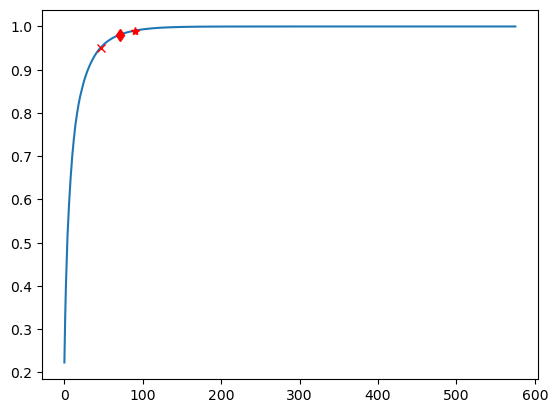

In [8]:
# Compute PCA of the demix impulse responses and store for later use in DNN training 
U, S, V = torch.pca_lowrank(torch.swapaxes(alldemixirs,-2,-1),q=len(spatconfigslabels)*4,center=True)
svdfname = Path(os.getcwd(),f"svd_demixirs_len{DEMIXFILTLEN}")
select99 = select_components(S,0.99)
select98 = select_components(S,0.98)
select95 = select_components(S,0.95)
torch.save({'U': U, 'S': S, 'V': V, 'select95': select95, 'select98': select98, 'select99': select99, 'Fs': Fs},svdfname)
plt.plot(torch.cumsum(S**2/torch.sum(S**2),0))
plt.plot(select95,0.95,'rx',select98,0.98,'rd',select99,0.99,'r*')

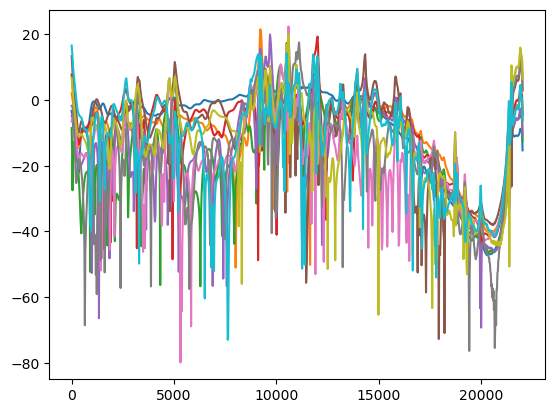

In [11]:
# Examine principal axes of the hrir dataset in the freq domain
Vft = torch.fft.fft(V,n=2048, dim=0)
fV = torch.arange(1024)/2048*44100
plt.plot(fV,20*torch.log10(torch.abs(Vft[:1024,:10])))

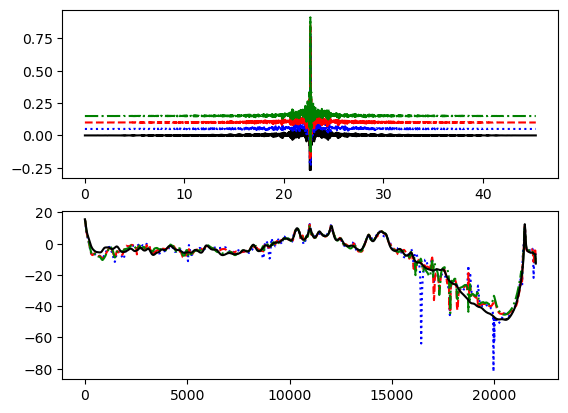

In [12]:
# project glall and grall on the eigenvector matrix in order to determine the compact representation
# test out by projecting just one hrir in the full glall, grall dataset
clall95 = torch.matmul(glall[:,0,0],V[:,:select95])
clall98 = torch.matmul(glall[:,0,0],V[:,:select98])
clall99 = torch.matmul(glall[:,0,0],V[:,:select99])
glest95 = torch.matmul(V[:,:select95],clall95)
glest98 = torch.matmul(V[:,:select98],clall98)
glest99 = torch.matmul(V[:,:select99],clall99)
lag = torch.arange(DEMIXFILTLEN)*1000/44100
plt.subplot(2,1,1)
plt.plot(lag,glall[:,0,0],'k-',lag,glest95+0.05,'b:',lag,glest98+0.1,'r--',lag,glest99+0.15,'g-.')
glft = torch.fft.fft(glall[:,0,0],n=2048)
ft95 = torch.fft.fft(glest95,n=2048)
ft98 = torch.fft.fft(glest98,n=2048)
ft99 = torch.fft.fft(glest99,n=2048)
plt.subplot(2,1,2)
plt.plot(fV,20*torch.log10(torch.abs(ft95[:1024])),'b:',
    fV,20*torch.log10(torch.abs(ft98[:1024])),'r--',
    fV,20*torch.log10(torch.abs(ft99[:1024])),'g-.',
    fV,20*torch.log10(torch.abs(glft[:1024])),'k-',
    )

In [9]:
#test the eigenvector projection function
glproj = xdmx.PCAproject(glall,select95)
grproj = xdmx.PCAproject(grall,select95)

In [10]:
glrecon = xdmx.invPCAproject(torch.swapaxes(torch.squeeze(glproj[0,:,:]),0,1))

In [11]:
glrecon.shape

torch.Size([1999, 2])

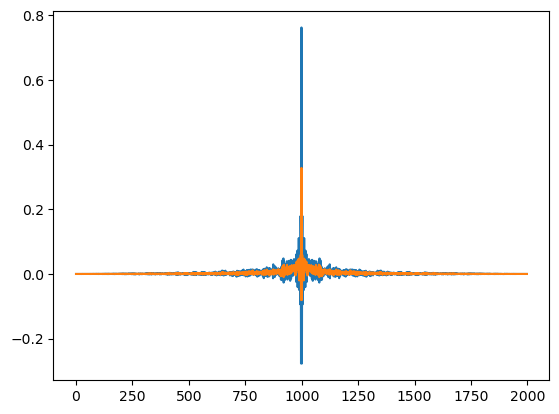

In [12]:
plt.plot(glrecon)

In [ ]:
os.getcwd()